In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
from torchsummary import summary

from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import PIL

## Transformations for images

In [76]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [77]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

## Dataset and Dataloader

In [78]:
root = '../data/rooms_split/'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
val_data = datasets.ImageFolder(os.path.join(root, 'val'), transform=test_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
val_loader = DataLoader(val_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Training images available: {len(val_data)}')
print(f'Testing images available:  {len(test_data)}')

['bathroom', 'bedroom', 'dining_room', 'kitchen', 'living_room']
Training images available: 91974
Training images available: 5106
Testing images available:  5108


Label: [3 1 0 1 4 3 4 4 4 1]
Class: kitchen bedroom bathroom bedroom living_room kitchen living_room living_room living_room bedroom


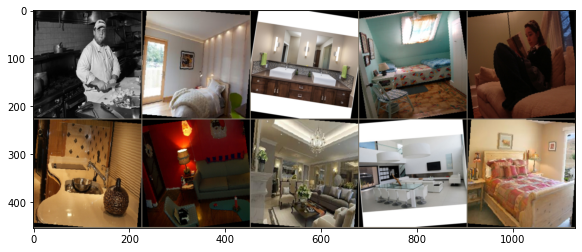

In [79]:
# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

## Model test

In [80]:
model = models.vgg19(pretrained=True)

In [81]:
for param in model.parameters():
    param.requires_grad = False

In [82]:
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

In [83]:
model.classifier = nn.Sequential(nn.Flatten(),
                                 nn.Linear(512,128),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(128,5),
                                 nn.LogSoftmax(dim=1))

In [84]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## Train model

In [85]:
torch.manual_seed(101)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [86]:
import time
start_time = time.time()

epochs = 10

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/91974]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(val_loader):
            
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/91974]  loss: 1.14949918  accuracy:  60.100%
epoch:  0  batch:  400 [  4000/91974]  loss: 0.49502030  accuracy:  65.650%
epoch:  0  batch:  600 [  6000/91974]  loss: 0.29335132  accuracy:  68.317%
epoch:  0  batch:  800 [  8000/91974]  loss: 0.59486187  accuracy:  69.112%
epoch:  0  batch: 1000 [ 10000/91974]  loss: 0.57140112  accuracy:  69.670%
epoch:  0  batch: 1200 [ 12000/91974]  loss: 0.26369175  accuracy:  70.517%
epoch:  0  batch: 1400 [ 14000/91974]  loss: 0.40806302  accuracy:  71.150%
epoch:  0  batch: 1600 [ 16000/91974]  loss: 0.39473179  accuracy:  71.562%
epoch:  0  batch: 1800 [ 18000/91974]  loss: 0.96980321  accuracy:  71.878%
epoch:  0  batch: 2000 [ 20000/91974]  loss: 0.32203934  accuracy:  72.195%
epoch:  0  batch: 2200 [ 22000/91974]  loss: 0.43475920  accuracy:  72.532%
epoch:  0  batch: 2400 [ 24000/91974]  loss: 0.47764987  accuracy:  72.683%
epoch:  0  batch: 2600 [ 26000/91974]  loss: 0.37790513  accuracy:  72.950%
epoch:  0  b

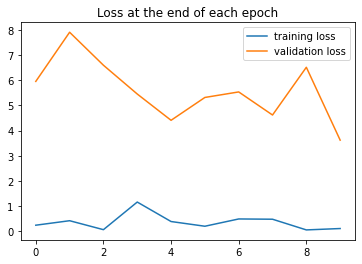

In [87]:
plt.plot([x.cpu().detach().numpy() for x in train_losses], label='training loss')
plt.plot([x.cpu().detach().numpy() for x in test_losses], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

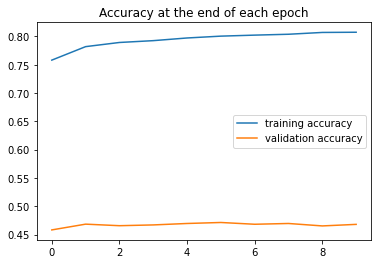

In [98]:
plt.plot([t.cpu().detach().numpy()/91974 for t in train_correct], label='training accuracy')
plt.plot([t.cpu().detach().numpy()/5106 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [96]:
train_correct

[tensor(69719, device='cuda:0'),
 tensor(71909, device='cuda:0'),
 tensor(72584, device='cuda:0'),
 tensor(72881, device='cuda:0'),
 tensor(73315, device='cuda:0'),
 tensor(73614, device='cuda:0'),
 tensor(73778, device='cuda:0'),
 tensor(73920, device='cuda:0'),
 tensor(74214, device='cuda:0'),
 tensor(74246, device='cuda:0')]

In [89]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

y_test_list = np.array([])
predict_list = np.array([])

with torch.no_grad():
    correct = 0
    for b, (X_test, y_test) in enumerate(test_loader):
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
        y_test_list = np.append(y_test_list, y_test.cpu().detach().view(-1).numpy())
        predict_list = np.append(predict_list, predicted.cpu().detach().view(-1).numpy())



In [90]:
predict_list

array([3., 2., 0., ..., 2., 1., 0.])

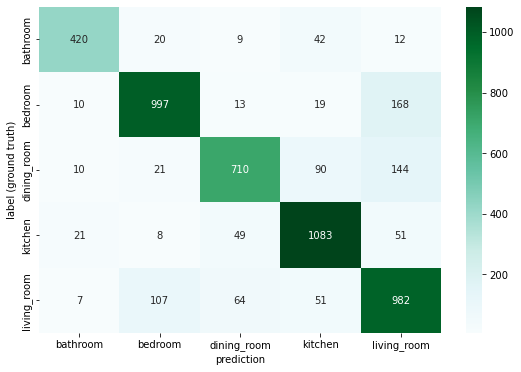

In [91]:
arr = confusion_matrix(y_test_list, predict_list)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

In [92]:
torch.save(model, "../models/first_try_vgg")